
# Define a simulator: Lotka-Volterra


Now let us look at another example, where it makes sense to derive a slightly more complex summary statistics.

The Lotka-Volterra (aka Prey-Predator) model is a model that describes the evolution of the population of two species (e.g. foxes and rabbits):

$\frac{du}{dt} = au - buv$  
$\frac{dv}{dt} = -cv + dbuv$

```
| a   | prey reproduction rate |
| b   | prey death rate per predator |
| c   | predator death rate (if no prey) |
| d   | predators born per prey |
```
```
| u   | prey / rabbits
| v   | predator / foxes
```

Code partially taken from: https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html

In [1]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
import pymc as pm
import numpy as np
import arviz as az
from scipy.integrate import odeint
import pytensor.tensor as pt
from pymc.distributions import Continuous
from pytensor.compile.ops import as_op
from sdeint import itoint
import torch
from sbi.utils import MultipleIndependent
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE
from sbi import utils as utils
from sbi.analysis.plot import pairplot
from sbi.inference import infer

t = np.linspace(0, 15, 1000)      # time
X0 = np.array([10.0, 5.0])        # initials conditions: 10 rabbits and 5 foxes


Let's assume that we observe the evolution of the population and we want to infer the parameters $a$ and $b$ (assume that $c$ and $d$ are known).

In [2]:
def run_model(theta, t, X0):
    a, b = theta
    c = 1.5
    d = 0.75

    def dX_dt(X, t):
        return [
            a * X[0] - b * X[0] * X[1],
            -c * X[1] + d * b * X[0] * X[1]
        ]

    # Solve the ODE
    X = odeint(dX_dt, X0, t)
    return X

Now let us display how the traces for a given set of parameters will look like

In [3]:
theta = [3.3, 0.29]  # parameters (a, b)
X = run_model(theta,t, X0)

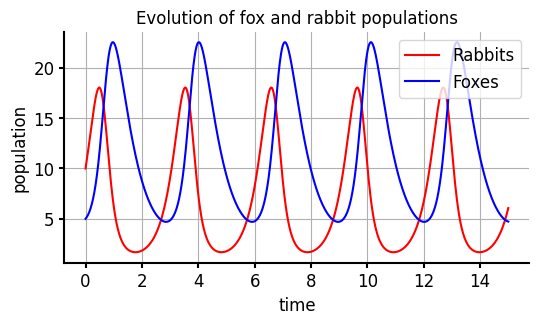

In [4]:
with mpl.rc_context(fname=".matplotlibrc"):
    rabbits, foxes = X.T
    f1 = plt.subplots(1, 1, figsize=(6, 3))
    plt.plot(t, rabbits, 'r-', label='Rabbits')
    plt.plot(t, foxes  , 'b-', label='Foxes')
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('population')
    plt.title('Evolution of fox and rabbit populations')
    plt.savefig("xo_lotka.png", dpi=200, bbox_inches="tight")
    plt.show()

We will assume, however, that there is some additive gaussian noise present in our observations, and hence the data will look as follows

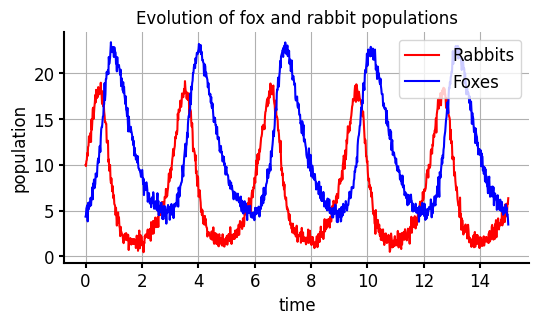

In [6]:
theta = [3.3, 0.29]  # parameters (a, b)
X = run_model(theta,t, X0)+np.random.normal(0, 0.5, (1000, 2))
with mpl.rc_context(fname=".matplotlibrc"):
    rabbits, foxes = X.T
    f1 = plt.subplots(1, 1, figsize=(6, 3))
    plt.plot(t, rabbits, 'r-', label='Rabbits')
    plt.plot(t, foxes  , 'b-', label='Foxes')
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('population')
    plt.title('Evolution of fox and rabbit populations')
    plt.savefig("xo_lotka.png", dpi=200, bbox_inches="tight")
    plt.show()

We will now write down a classical MCMC model for inferring Lotka-Volterra parameters, based on the assumptions that our observations on the population of rabbits $X_r$ and foxes $X_f$ read as follows $X_r=u+\epsilon$, $X_f=v+\epsilon$, where $\epsilon\sim N(0,0.1)$. Here, $u$ and $v$ will be the solutions of the ODE system described above. We will also assume uniform prior distributions on ourparameters $a$ and $b$. 

Namely, $a\sim U[0.5,3.5]$, $b\sim U[0,0.5]$

The below code for MCMC inference is written in PyMC. Studying PyMC is not within the scope of this course and we use MCMC here exclusively for illustrating purposes and for results comparison. Therefore, we are not discussing the code here.

In [7]:
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    t = np.linspace(0, 15, 1000)  # Time points
    X0 = np.array([10.0, 5.0])    # Initial conditions
    return run_model(theta, t, X0)


def create_pymc_model(observed_data):
    with pm.Model() as model:
        # Priors for the parameters
        a = pm.Uniform('a', lower=0.5, upper=3.5)
        b = pm.Uniform('b', lower=0.0, upper=0.5)
        sigma = pm.InverseGamma('sigma', alpha=3.0, beta=1.0)


        # Combine the parameters into a single vector
        theta = pt.stack([a, b])

        # Use the PyTensor operation
        simulated = pytensor_forward_model_matrix(theta)

        # Likelihood
        likelihood = pm.Normal('likelihood', mu=simulated, sigma=sigma, observed=observed_data)

        # Sample from the posterior
        trace = pm.sample(5000, tune=1000, return_inferencedata=True)

    return model, trace

We will now generate a predator-prey model with the true parameters $a=2.0$, $b=0.2$ and visualise the traces of 4 Markov Chains along with the resulting posterior parameter distributions

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [a]
>>Slice: [b]
>NUTS: [sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 152 seconds.


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

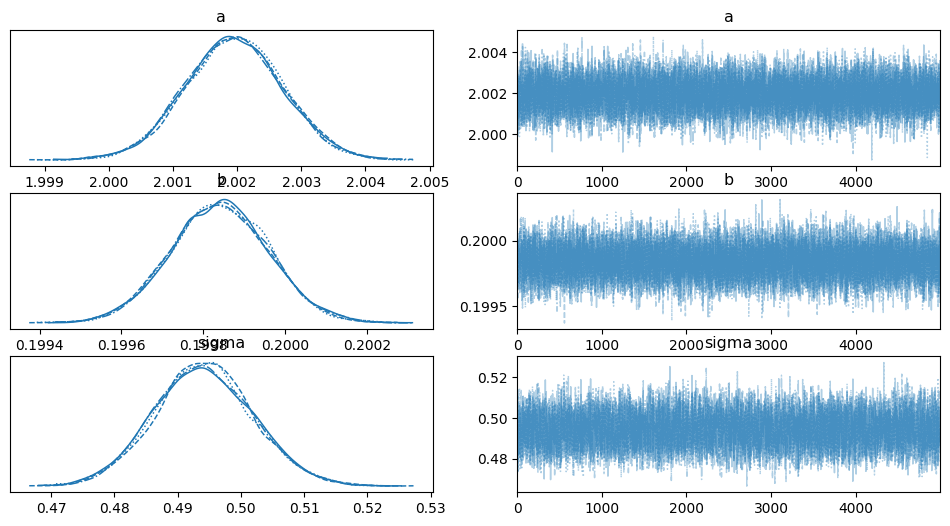

In [9]:
np.random.seed(42)
t = np.linspace(0, 15, 1000)  # Time points
X0 = np.array([10.0, 5.0])    # Initial conditions
true_params = [2.0, 0.2]
observed_data = run_model(true_params, t, X0) + np.random.normal(0, 0.5, size=(len(t), 2))

# Create the model and sample
model, trace = create_pymc_model(observed_data)

# Analyze the results
az.summary(trace)
az.plot_trace(trace)

We note that although the posterior distributions are very narrow, the true values of the parameters lie closer to the boundary of the bulk of the distributions and do not coincide with the modes.

### Putting the model into SBI framework

We can easily convert this model into the SBI framework, especially given that we already have a simulator defined via `def run_model`, and can generate multiple samples, every time adding Gaussian $N(0,0.1)$ noise to it.

Note, that all the distributions either need to belong to `sbi` package or `torch.distributions`, and the parameters of the distributions have to be defined as `torch.Tensors`


Let us infer the variable `posterior` which is going to correspond to posterior distribution in case we use SNPE method. This will essentially infer the whole approximate posterior distribution using normalizing flows, whilst if using SNLE or SNRE only parts of posterior, likelihood and likelihood ratio respectively, will be approximated via neural network, and subsequent MCMC inference will still be required.

We define the prior distributions on the parameters exactly in the same way as we did for the case of classical MCMC above, namely both of them are uniformly distributed

In [10]:
# lower_bound = torch.tensor([0.5, 0.0])
# upper_bound = torch.tensor([3.5, 0.5])
# prior = utils.BoxUniform(lower_bound, upper_bound)
prior = MultipleIndependent(
    [torch.distributions.Uniform(torch.tensor([0.5]),torch.tensor([3.5]))]+\
    [torch.distributions.Uniform(torch.tensor([0.0]),torch.tensor([0.5]))]+\
    [torch.distributions.InverseGamma(torch.tensor([3.0]),torch.tensor([1.0]))]
)

We will now create a `simulator` wrapper for our `run_model` function, so that it returns a one-dimensional tensor. Note, that the output of our model has two dimensions, since it returns traces of two populations, and therefore it will need to be flattened.

After defining our simulator we immediately proceed with SBI inference using one-liner interface. This performs the simulations, posterior inference and building in one step. 

Note, that here we are using SNPE method for posterior inference. This means that the posteropr function $p(\theta|x)$ is being approximated by means of normalizing flow. In terms of neural network inputs it means, that values obtained from the prior distribution $\theta$ are passed to the model, and the simulation outputs (data) $x$ serve as a condition (i.e. the space of all values of $x$ is not explored by the model). SNPE method is generally useful, if one believes that the chosen model fairly accurately reflects the reality. In case one needs more flexibility, it is advised to resort to more flexible methods, such as SNLE or SNRE

In [11]:
def simulator(theta):
    trace = run_model(theta[:2], t, X0) + np.random.normal(0, theta[2], size=(len(t), 2))
    trace=trace.reshape(-1)
    return torch.as_tensor(trace, dtype=torch.float32)

posterior = infer(simulator, prior, method="SNPE", num_simulations=5000,num_workers=-1)

  0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 86 epochs.

Use the above observation to sample from the posterior distribution, while appropriately reshaping it

In [12]:
samples_NPE = posterior.sample((10000,), x=observed_data.reshape((1,2000)))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Plot the distributions of the parameters $a$ (dim 1) and $b$ (dim 2)

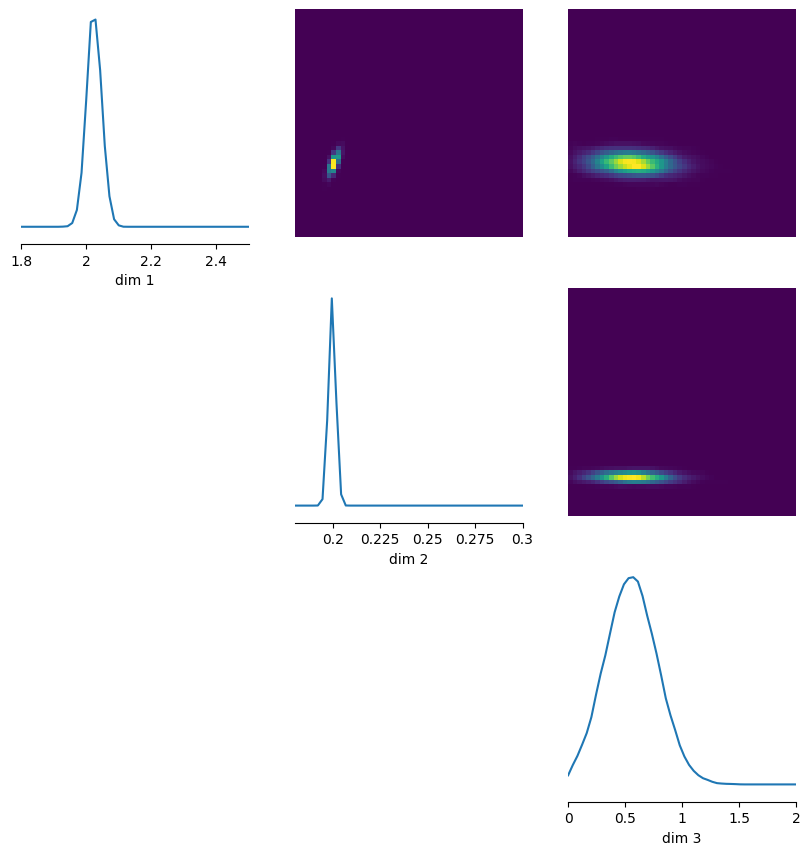

In [20]:
fig, out = pairplot(samples_NPE, limits=[[1.8,2.5],[0.18,0.3],[0.0,2.0]], fig_kwargs={'fig_size':(3,3)}, upper='kde', diag='kde')

The results of the SBI inference look different from the MCMC one. Firstly, we note that the resulting posterior distributions are way broader, than in case of MCMC. This is to be expected, since SBI is relying on the unconstrained simulations and an approximate likelihood, while MCMC is guided by the exact likelihood coming from a fairly simple noise model. Of note here, is that the ground truth values in case of SBI lie way closer to the mode of the distribution than in case of MCMC. This may largely be related to the choice of the prior distributions and the fact that MCMC generallyis not very good with handling priors with sharp bounds. As an exercise, one can change the Uniform priors to the ones with infinite support and see how the inference changes.

### Using SNLE

As mentioned above, SNLE and SNRE are methods which allow for more modelling flexibility. SNLE approximates the likelihood function of the posterior distribution $f(x|\theta)$, which generally requires more complex inference as, unlike in case of SNPE, it is exploring both the sapce of simulation outputs $x$ and prior values $\theta$, which are both inputs of the normalizing flow, and therefore may require more training time as we will see below.

In [14]:
posterior = infer(simulator, prior, method="SNLE", num_simulations=5000,num_workers=-1)

  0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 305 epochs.

/p/project1/atmlaml/bazarova1/sbi_intro/sbi_env/venv/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


In addition to more complex training procedure, since it is only the likelihood function which is approximated by the neural network, an actual MCMC algorithm will need to be run afterwards, in order to infer the full posterior, which also may take more time. A good use-case of the SNLE model is when one is not sure about the prior distribution and wants to compare the models with different prior distributions.

In [15]:
samples_NLE = posterior.sample((10000,), x=observed_data.reshape((1,2000)))

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

On the other hand, given that SNLE is generally more reminiscient of the classical MCMC procedure, the outputs are partially guided by the respective theory and hence the resulting distributions are tighter than in case of SNPE, thereby reducing uncertainty.

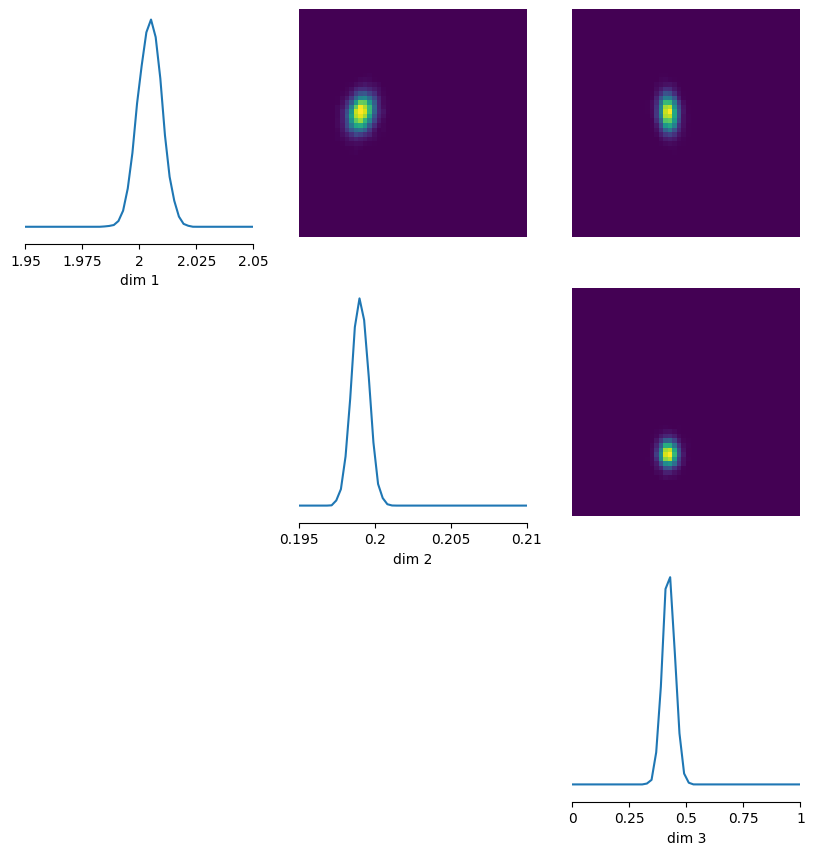

In [16]:
fig, out = pairplot(samples_NLE, limits=[[1.95,2.05],[0.195,0.21],[0.0,1.0]], fig_kwargs={'fig_size':(3,3)}, upper='kde', diag='kde')

### Using SNRE

SNRE method breaks the posterior further down by approximating only the likelihood-ratio part $\frac{p(x|\theta_0)}{p(x|\theta_1)}$ of the MCMC Metropolis-Hastings step, where $\theta_0$ and $\theta_1$ is the current and proposed values of the Markov Chain. The key difference of this method from the two previous ones, is that unlike the normalizing flows here a neural network classifier, learning to discriminate between samples from $p(x|\theta_0)$ and $p(x|\theta_1)$ is used. In theory, it an be any classifier, the default value within the `sbi-toolkit` is ResNet. Of note, is that this type of network does not require an approximation of a complex function, which leads to significantly reduced running times, even though, similarly to the case of SNLE, an actual MCMC needs to be run after the neural density estimation.

In [17]:
posterior = infer(simulator, prior, method="SNRE", num_simulations=5000,num_workers=-1)

  0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 104 epochs.

In [18]:
samples_NRE = posterior.sample((10000,), x=observed_data.reshape((1,2000)))

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

The pinch of salt in using SNRE is that since it does not perform a complex function approximation, it may not capture the intricate details of the distribution and result in the way less confident outputs as below

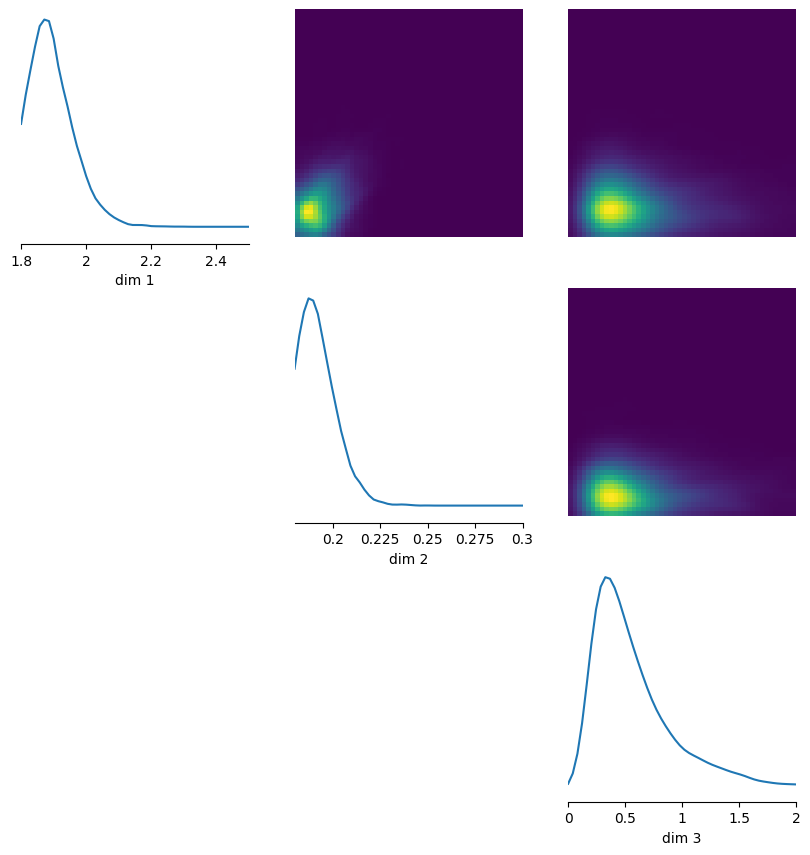

In [19]:
fig, out = pairplot(samples_NRE, limits=[[1.8,2.5],[0.18,0.3],[0.0,2.0]], fig_kwargs={'fig_size':(3,3)}, upper='kde', diag='kde')